In [1]:
from transformers import TFResNetModel, AutoImageProcessor
from datasets import load_dataset
import tensorflow as tf
from keras import Sequential, layers
import numpy as np

# Load Pretrained Model

## Save Resnet Weigths and Model

In [2]:
resnet_50 = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet'
)

In [189]:
#resnet_50.save("./models/resnet50")
#resnet_50.save_weights("./models/resnet50/checkpoints/")

# Prepare Pretrained Base

In [5]:
resnet_50 = tf.keras.models.load_model("./models/resnet50")
resnet_50.load_weights("./models/resnet50/checkpoints/")

InvalidArgumentError: Multiple OpKernel registrations match NodeDef at the same priority '{{node AssignVariableOp}}': 'op: "AssignVariableOp" device_type: "GPU" constraint { name: "dtype" allowed_values { list { type: DT_INT64 } } } host_memory_arg: "resource"' and 'op: "AssignVariableOp" device_type: "GPU" constraint { name: "dtype" allowed_values { list { type: DT_INT64 } } } host_memory_arg: "resource"'
	 [[AssignVariableOp]] [Op:AssignVariableOp]

In [4]:
resnet_50.trainable = False # freeze layers

# Create Model

In [5]:
inputs = tf.keras.Input(shape=(150,150,3))
x = resnet_50(inputs, training=False)
x = layers.Flatten()(x)
outputs = layers.Dense(12, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 12)                614412    
                                                                 
Total params: 24,202,124
Trainable params: 614,412
Non-trainable params: 23,587,712
_________________________________________________________________


# Get Testdata (DONT RUN ANYMORE!)

- moved 10% of each category to test_data folder
- dont run this anymore!

In [16]:
run = False

from os import walk, rename
path = "./data/Animal Image Dataset/"

if run:
    d = []
    for (dirpath, dirnames, filenames) in walk(path):
        d.extend(dirnames)
        break

    for folder in d:
        f = []
        c_path = f"{path}{folder}"
        for (dirpath, dirnames, filenames) in walk(c_path):
            f.extend(filenames)
            break
        for ff in f[0:len(f)//10]:
            #rename(f"{path}{folder}/{ff}", f"{path}test_data/{folder}/{ff}") # this moves the files

# Load Data

In [7]:
data_dir = "./data/Animal Image Dataset"
image_height = 150
image_width = 150
batch_size = 10

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 15462 files belonging to 12 classes.
Using 12370 files for training.
Found 15462 files belonging to 12 classes.
Using 3092 files for validation.


In [12]:
test_data_dir = "./data/test_data"

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 1715 files belonging to 12 classes.


In [8]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Train Model

In [10]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
1237/1237 [==============================] - 38s 28ms/step - loss: 5.2066 - accuracy: 0.8062 - val_loss: 5.1637 - val_accuracy: 0.8399
Epoch 2/3
1237/1237 [==============================] - 26s 21ms/step - loss: 2.0669 - accuracy: 0.9258 - val_loss: 4.5418 - val_accuracy: 0.8645
Epoch 3/3
1237/1237 [==============================] - 27s 22ms/step - loss: 1.2762 - accuracy: 0.9546 - val_loss: 4.7959 - val_accuracy: 0.8668


# Test Model

In [13]:
model.evaluate(test_ds)

172/172 [==============================] - 11s 57ms/step - loss: 5.2662 - accuracy: 0.8531


[5.266226768493652, 0.8530611991882324]

1/1 [==============================] - 0s 32ms/step


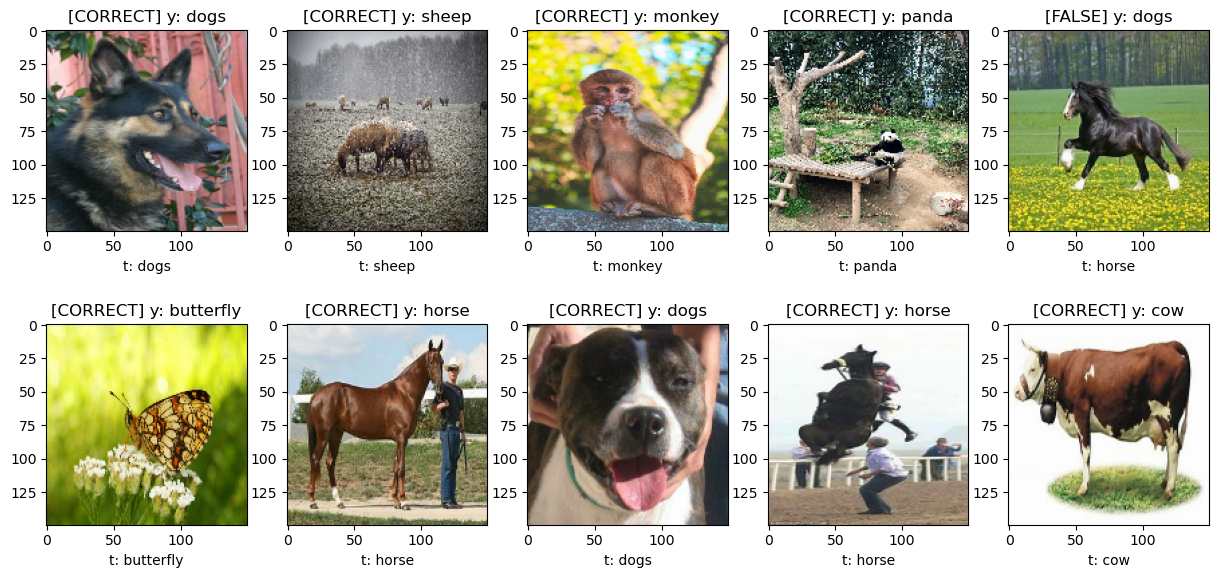

In [108]:
class_names = test_ds.class_names
batch = test_ds.take(1)
plt.figure(figsize=(15,7))
for images, labels in batch:
    prediction = model.predict(images)
    for i in range(batch_size):
        y = class_names[np.argmax(prediction[i])]
        t = class_names[labels[i]]
        if y == t:
            title = f"[CORRECT] y: {y}"
        else:
            title = f"[FALSE] y: {y}"
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(title)
        plt.xlabel(f"t: {t}")